We will try to understand some aspects of GNN (graph neural networks). GNNs are one of the most interesting and fast-growing architectures in deep learning. Among all GNNs, the Graph Convolutional Networks (GCNs) are the most popular and widely-applied. We try to apply it to node classification using PyTorch Geometric.

PyTorch Geometric is an extension of PyTorch dedicated to GNNs.
We use https://en.wikipedia.org/wiki/Zachary%27s_karate_club dataset.

Adapted from: https://mlabonne.github.io/blog/intrognn/

In [29]:
import torch
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
from torch_geometric.datasets import KarateClub
dataset = KarateClub()

print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
KarateClub()
------------
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [30]:
print(f'Graph: {dataset[0]}')

Graph: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [31]:
data = dataset[0]
print(f'x = {data.x.shape}')
print(data.x)

x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


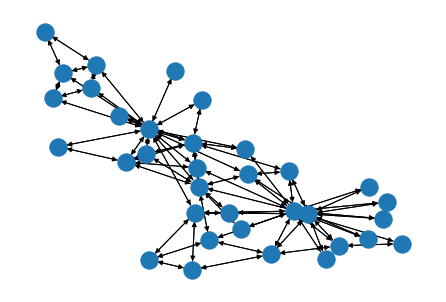

In [32]:
import networkx as nx
from torch_geometric.utils import *
g = to_networkx(data, to_undirected=False)
nx.draw(g)

In [33]:
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3, 

These give us the starting and ending of an edge. Here, we have two lists of 156 directed edges (78 bidirectional edges) because the first list contains the sources and the second one the destinations. It is called a coordinate list (COO) and is just one way of efficiently storing a sparse matrix. The adjacency matrix can be inferred from the edge_index with a utility function.

In [34]:
from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

A = (34, 34)
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


In [35]:
def isSymmetric(mat, N):
    for i in range(N):
        for j in range(N):
            if (mat[i][j] != mat[j][i]):
                return False
    return True

In [36]:
isSymmetric(A, 34)

True

In [37]:
print(f'y = {data.y.shape}')
print(data.y)

y = torch.Size([34])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


We see that it has 4 classes

In [38]:
print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)

train_mask = torch.Size([34])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


The train mask shows which nodes are supposed to be used for training with True statements. These nodes represent the training set, while the others can be considered as the test set.

In [39]:
print(f'Edges are directed: {data.is_directed()}') # Adjacency matrix not symmetric?
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


We plotted the graph before but now we do it with colors. 

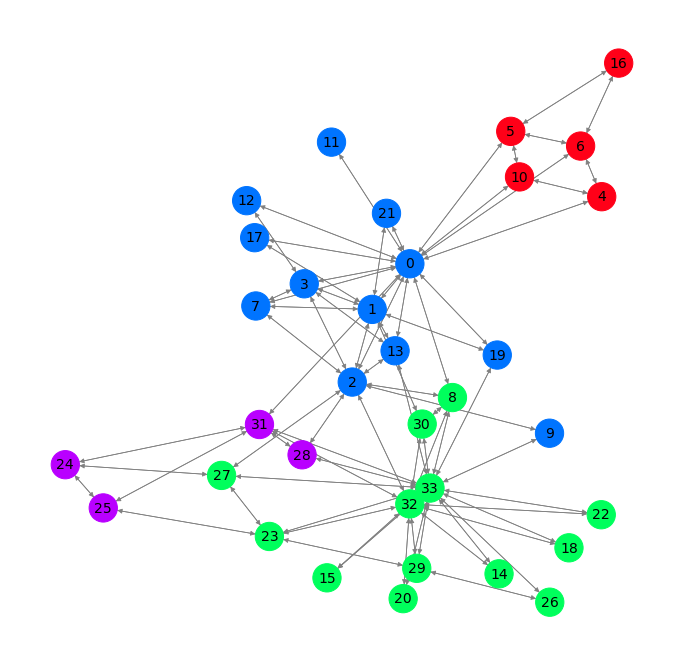

In [40]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=False)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()